# Image stitching
Today’s exercise is different from the previous weeks in that it has only a few exercises followed by multiple options for how to improve your algorithm. You are going to implement an algorithm that can stitch at least two images together, by using RANSAC to estimate a homography.
Start out with using `im1` and `im2`.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
im1 = cv2.imread('data/im1.jpg')[:, :, ::-1]
im2 = cv2.imread('data/im2.jpg')[:, :, ::-1]

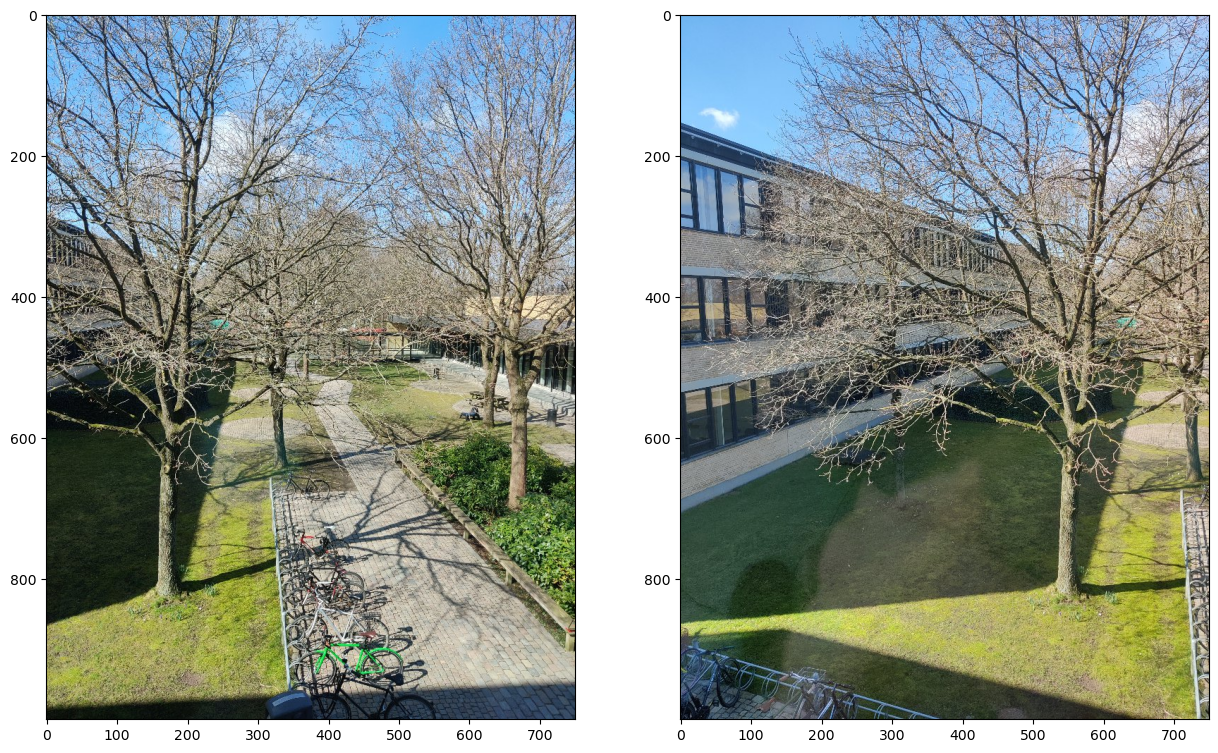

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15), dpi=100)
ax1.imshow(im1)
ax2.imshow(im2)
plt.show()

## Exercise 10.1
Find `SIFT` keypoints (`kp1`, `kp2`) in both images and compute their descriptors (`des1`, `des2`). Match the `SIFT` features from both images to each other. Make sure to use cross checking.

In [5]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key = lambda x:x.distance)
matched_image = cv2.drawMatches(im1,
           kp1, im2, kp2, matches[:60], None,
           matchColor=(0, 255, 0), matchesMask=None,
           singlePointColor=(255, 0, 0), flags=0)

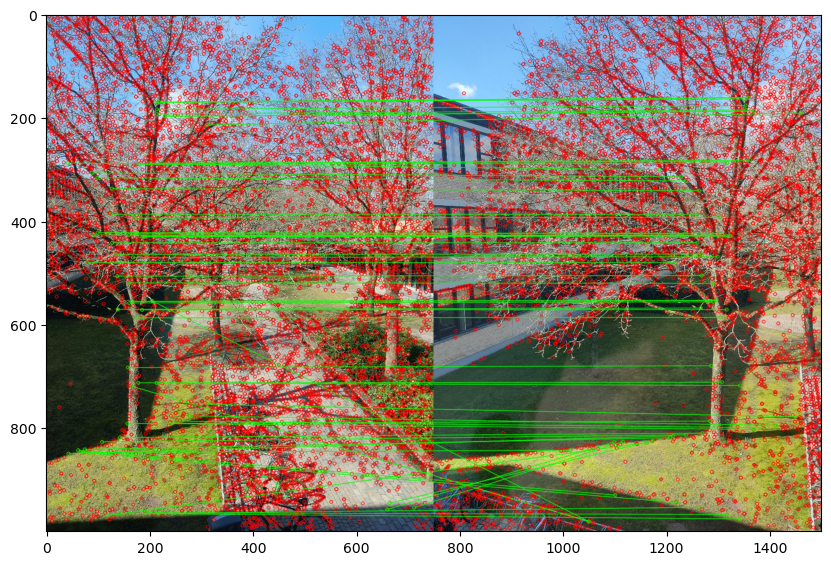

In [6]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(matched_image)
plt.show()

In [7]:
pts_im1 = []
pts_im2 = []

for match in matches:
    pts_im1.append(kp1[match.queryIdx].pt)
    pts_im2.append(kp2[match.trainIdx].pt)

pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = np.array(pts_im2, dtype=np.float32).T

In [8]:
pts_im1.shape, pts_im2.shape

((2, 2452), (2, 2452))

In [9]:
point_map = np.array([
        [kp1[match.queryIdx].pt[0],
         kp1[match.queryIdx].pt[1],
         kp2[match.trainIdx].pt[0],
         kp2[match.trainIdx].pt[1]] for match in matches
    ])

In [10]:
point_map

array([[135.28997803, 464.29980469, 517.40698242, 463.81365967],
       [171.80525208, 423.84262085, 554.49127197, 423.63259888],
       [240.12968445, 791.66888428, 618.90496826, 803.11444092],
       ...,
       [357.84185791, 797.95550537, 120.15899658, 589.04418945],
       [541.68286133, 831.43200684, 669.94317627, 271.60534668],
       [648.31567383, 553.48730469, 596.53820801, 230.48596191]])

## Exercise 10.2
Implement a `RANSAC` algorithm for finding the homography between `im1` and `im2`.
What is the minimum number of matches you need to estimate a homography? (Tip: it’s four)
Explain why this is the case.
Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography.
Assume $\sigma = 3$ and use the formulas from the lecture last week to determine the threshold for when a match should be considered an inlier.
While best practice would be to determine the number of iterations while running the algorithm, you can fix it to i.e. 200.
To verify that the inliers of the best model are reasonable, visualize them. Consider using the following code:
`plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))`
On the provided images you should find in the ballpark of a thousand inliers.

\begin{equation}
    dist_{approx}^{2} = ||\tilde{q_{1}} - \Pi(H\tilde{p}_{2})||_{2}^{2} + ||\tilde{q}_{2} - \Pi(H^{-1} \tilde{p}_{1}))||_{2}^{2}
\end{equation}

In [11]:
from CV_utils import Pi, PiInv

In [12]:
def crossOp(p):
    x = p[0]
    y = p[1]
    z = p[2]
    #z = 1
    cross_p = np.array([[0, -z, y],
                        [z, 0, -x],
                        [-y, x, 0]])
    return cross_p

def hest(q1, q2):
    
    B = np.vstack([np.kron(q2[:, i].T, crossOp(q1[:, i])) for i in range(len(q2.T))])

    _, _, Vh = np.linalg.svd(B)
    V = Vh.T

    #Estimate homography
    H_est = V[:, -1].reshape(3,3).T

    np.testing.assert_almost_equal(np.linalg.norm(H_est), 1)

    #Normalizing
    H_est = H_est / H_est[2,2]

    return H_est

def sample_points(q1_list, q2_list):
    #In array form
    points_len = len(q1_list.T)
    num_range = np.arange(points_len)
    random_indices = np.random.choice(num_range, size = 4, replace=False)
    random_sample_q1 = q1_list[:,random_indices]
    random_sample_q2 = q2_list[:,random_indices]
    #Returns sample of shape D x N
    return random_sample_q1, random_sample_q2

def dist(H_est, q1, q2):
    dist = np.linalg.norm(Pi(H_est@q2) - Pi(q1))**2 + np.linalg.norm(Pi(np.linalg.inv(H_est)@q1) - Pi(q2))**2
    return dist

In [13]:
def est_HomographyRANSAC(kp1, des1, kp2, des2,num_iterations = 200, sigma = 3):

    bf = cv2.BFMatcher_create(crossCheck=True)
    matches = bf.match(des1, des2)

    pts_match_im1 = []
    pts_match_im2 = []

    for match in matches:
        pts_match_im1.append(kp1[match.queryIdx].pt)
        pts_match_im2.append(kp2[match.trainIdx].pt)

    pts_im1 = np.array(pts_match_im1, dtype=np.float32).T
    pts_im2 = np.array(pts_match_im2, dtype=np.float32).T

    q1_list = PiInv(pts_im1)
    q2_list = PiInv(pts_im2)

    best_inlier_indexes = []
    for _ in range(num_iterations):

        inlier_indexes = []
        sample_pts_q1, sample_pts_q2= sample_points(q1_list, q2_list)

        H_est = hest(sample_pts_q1, sample_pts_q2)

        for i in range(len(q1_list.T)):
            if dist(H_est, q1_list[:,i], q2_list[:,i]) < 3.84*sigma**2:
                inlier_indexes.append(i)

        if len(inlier_indexes) > len(best_inlier_indexes):
            best_inlier_indexes = inlier_indexes

    print(f"The number of optimal inliers: {len(best_inlier_indexes)}")
    H_est_new = hest(q1_list[:,best_inlier_indexes], q2_list[:, best_inlier_indexes])

    plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[best_inlier_indexes], None), origin = 'upper')

    return H_est_new

## Exercise 10.3
Wrap your code from the previous exercise in a function: `H = estHomographyRANSAC(kp1, des1, kp2, des2)`.
The function should take SIFT keypoints and descriptors computed on two images and use RANSAC to estimate the best homography between the images.
Make sure that the function ends with fitting a homography to the largest amount of inliers.

The number of optimal inliers: 374


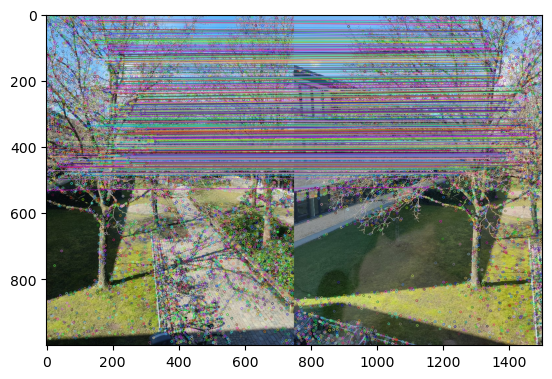

In [14]:
H_est = est_HomographyRANSAC(kp1, des1, kp2, des2)

## Exercise 10.4

Run the function on im1 and im2. You can use the following function for warping the images using
your homography. 

In [15]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp

It takes an image and a homography and returns the image warped with the homography, where
xRange and yRange specifies for which range of x and y values the image should be sampled. The
function returns the transformed version of the image, and a mask that is 1 where the image is
valid.

Start out by setting

`xRange = [0, im1.shape[1]]`

`yRange = [0, im1.shape[0]]`

Warp one of your images using the estimated homography. Which image you should warp, depends
on if you have found the homography going from image one to two or vice versa. This should warp
this image to the other, thus cutting off a lot of the content of that image.
Use the warping function on the other image but set the homography to the identity. Change
xRange and yRange so the images are no longer getting cropped by the warp.

## Exercise 10.5


Use the mask returned by the warping function, to generate a single image that contains both
images. Where the images overlap you can use the intensities from either image.

In [16]:
xRange = [-600, im1.shape[1]]
yRange = [0, im1.shape[0]] 
# Warp the images with the estimated homography
im1_warped, mask1_warped = warpImage(im1, np.eye(3), xRange, yRange)
im2_warped, mask2_warped = warpImage(im2, H_est, xRange, yRange)

In [17]:
# Create an array of zeros
result = np.zeros_like(im1_warped)

# Set the values of the warped images to the array of zeros using the masks
result[mask1_warped != 0] = im1_warped[mask1_warped != 0]
result[mask2_warped != 0] = im2_warped[mask2_warped != 0]

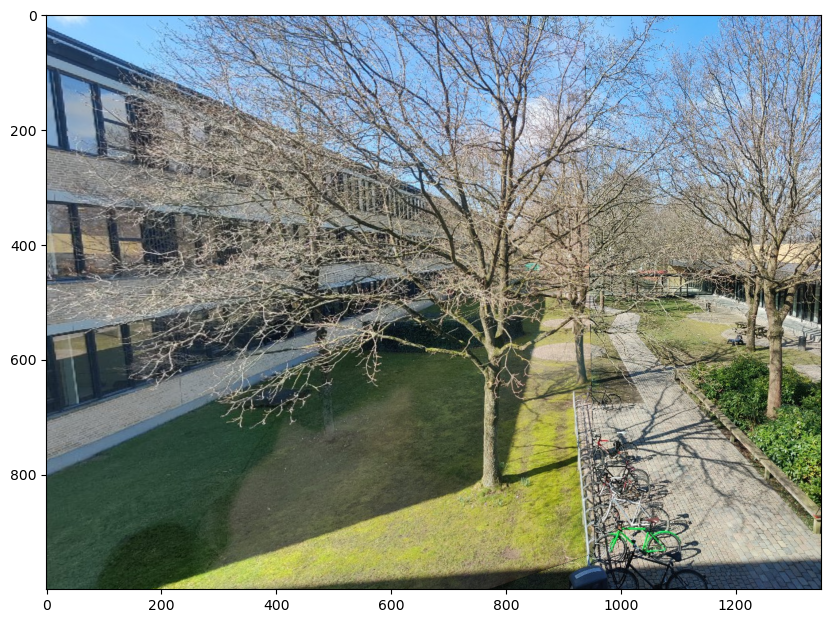

In [18]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(result)
plt.show()

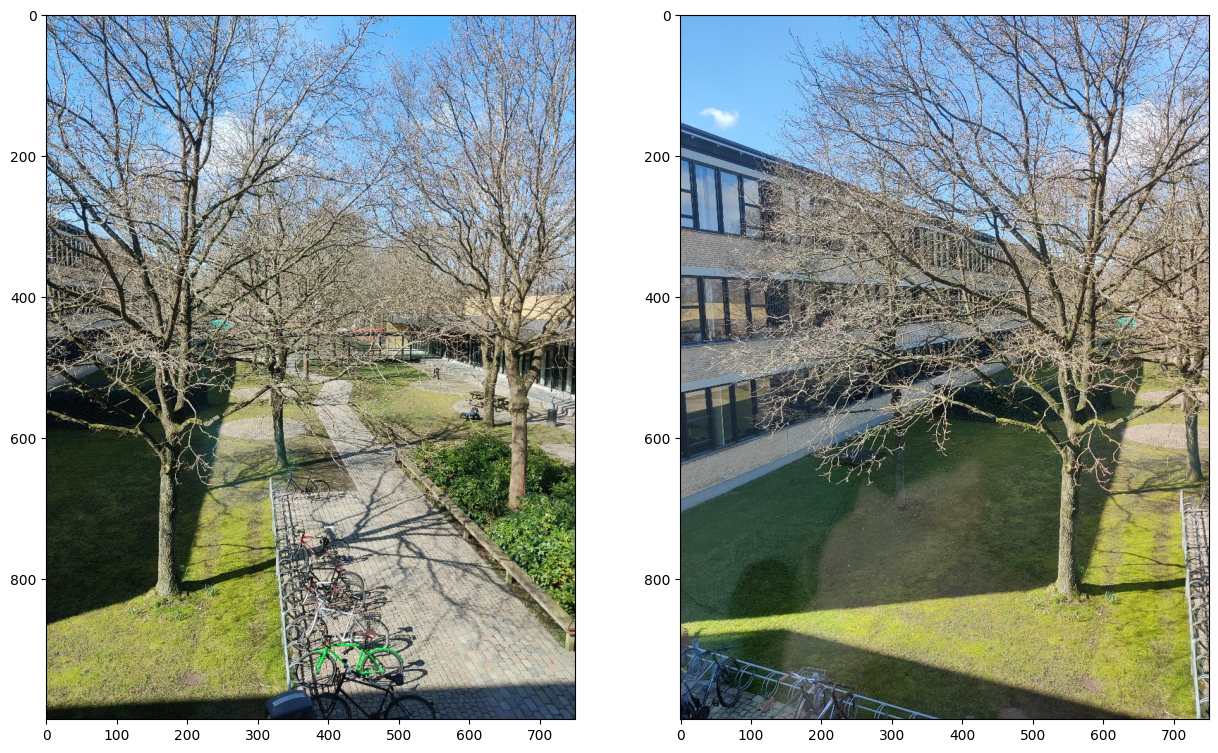

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), dpi=100)
ax1.imshow(im1)
ax2.imshow(im2)
plt.show()